<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-3-public/blob/main/Course%202%20-%20Custom%20Training%20loops%2C%20Gradients%20and%20Distributed%20Training/Week%204%20-%20Distribution%20Strategy/C2_W4_Lab_3_using-TPU-strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPU Strategy 

In this ungraded lab you'll learn to set up the TPU Strategy. It is recommended you run this notebook in Colab by clicking the badge above. This will give you access to a TPU as mentioned in the walkthrough video. Make sure you set your `runtime` to `TPU.`

## Imports

In [1]:
import os
import random
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print("TensorFlow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.6.0


## Set up TPUs and initialize TPU Strategy

Ensure to change the runtime type to TPU in Runtime -> Change runtime type -> TPU

In [2]:
# Detect hardware
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address) # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) 
  # Going back and forth between TPU and host is expensive.
  # Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
  print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
  print('TPU failed to initialize.')

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.123.62.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.123.62.242:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  ['10.123.62.242:8470']
Number of accelerators:  8


## Download the Data from Google Cloud Storage


In [3]:
SIZE = 224 #@param ["192", "224", "331", "512"] {type:"raw"}
IMAGE_SIZE = [SIZE, SIZE]

In [4]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-{}x{}/*.tfrec'.format(IMAGE_SIZE[0], IMAGE_SIZE[1])

BATCH_SIZE = 128  # On TPU in Keras, this is the per-core batch size. The global batch size is 8x this.

VALIDATION_SPLIT = 0.2
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
random.shuffle(filenames)

split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))

validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


## Create a dataset from the files

- load_dataset takes the filenames and turns them into a tf.data.Dataset
- read_tfrecord parses out a tf record into the image, class and a one-hot-encoded version of the class
- Batch the data into training and validation sets with helper functions


In [5]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = example['image']
    class_label = example['class']
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    class_label = tf.cast(class_label, tf.int32)
    return image, class_label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
  # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=False) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

def get_training_dataset():
  dataset = get_batched_dataset(training_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

def get_validation_dataset():
  dataset = get_batched_dataset(validation_filenames)
  dataset = strategy.experimental_distribute_dataset(dataset)
  return dataset

## Define the Model and training parameters

In [6]:
class MyModel(tf.keras.Model):
  def __init__(self, classes):
    super(MyModel, self).__init__()
    self._conv1a = tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu')
    self._conv1b = tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu')
    self._maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=2)
    
    self._conv2a = tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu')
    self._maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=2)
    
    self._conv3a = tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu')
    self._maxpool3 = tf.keras.layers.MaxPooling2D(pool_size=2)
    
    self._conv4a = tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu')
    self._maxpool4 = tf.keras.layers.MaxPooling2D(pool_size=2)
    
    self._conv5a = tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu')
    self._conv5b = tf.keras.layers.Conv2D(kernel_size=3, filters=40, padding='same', activation='relu')
    
    self._pooling = tf.keras.layers.GlobalAveragePooling2D()
    self._classifier = tf.keras.layers.Dense(classes, activation='softmax')

  def call(self, inputs):
    x = self._conv1a(inputs)
    x = self._conv1b(x)
    x = self._maxpool1(x)

    x = self._conv2a(x)
    x = self._maxpool2(x)

    x = self._conv3a(x)
    x = self._maxpool3(x)

    x = self._conv4a(x)
    x = self._maxpool4(x)

    x = self._conv5a(x)
    x = self._conv5b(x)

    x = self._pooling(x)
    x = self._classifier(x)
    return x

In [7]:
with strategy.scope():
  model = MyModel(classes=len(CLASSES))
  # Set reduction to `none` so we can do the reduction afterwards and divide by
  # global batch size.
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions):
    per_example_loss = loss_object(labels, predictions)
    return tf.nn.compute_average_loss(per_example_loss, global_batch_size=BATCH_SIZE * strategy.num_replicas_in_sync)

  test_loss = tf.keras.metrics.Mean(name='test_loss')

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='test_accuracy')
  
  optimizer = tf.keras.optimizers.Adam()

  @tf.function
  def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step,args=(dataset_inputs,))
    print(per_replica_losses)
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                           axis=None)
 
  @tf.function
  def distributed_test_step(dataset_inputs):
    strategy.run(test_step, args=(dataset_inputs,))


  def train_step(inputs):
    images, labels = inputs

    with tf.GradientTape() as tape:
      predictions = model(images)
      loss = compute_loss(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_accuracy.update_state(labels, predictions)

    return loss 

  def test_step(inputs):
    images, labels = inputs

    predictions = model(images)
    loss = loss_object(labels, predictions)

    test_loss.update_state(loss)
    test_accuracy.update_state(labels, predictions)


In [8]:
EPOCHS = 40
with strategy.scope():
  for epoch in range(EPOCHS):
    # TRAINING LOOP
    total_loss = 0.0
    num_batches = 0
    for x in get_training_dataset():
      total_loss += distributed_train_step(x)
      num_batches += 1
    train_loss = total_loss / num_batches

    # TESTING LOOP
    for x in get_validation_dataset():
      distributed_test_step(x)

    template = ("Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, "
                "Test Accuracy: {:.2f}")
    print (template.format(epoch+1, train_loss,
                           train_accuracy.result()*100, test_loss.result() / strategy.num_replicas_in_sync,
                           test_accuracy.result()*100))

    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
PerReplica:{
  0: Tensor("output_0_shard_0:0", shape=(), dtype=float32),
  1: Tensor("output_0_shard_1:0", shape=(), dtype=float32),
  2: Tensor("output_0_shard_2:0", shape=(), dtype=float32),
  3: Tensor("output_0_shard_3:0", shape=(), dtype=float32),
  4: Tensor("output_0_shard_4:0", shape=(), dtype=float32),
  5: Tensor("output_0_shard_5:0", shape=(), dtype=float32),
  6: Tensor("output_0_shard_6:0", shape=(), dtype=float32),
  7: Tensor("output_0_shard_7:0", shape=(), dtype=float32)
}
PerReplica:{

## Predictions

In [9]:
#@title display utilities [RUN ME]
import matplotlib.pyplot as plt

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      numpy_images, numpy_labels = ses.run(get_next_item)

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  # correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [10]:
inference_model = model

In [11]:
some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

['sunflowers', 'roses', 'sunflowers', 'roses', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'tulips', 'roses', 'dandelion', 'roses', 'dandelion', 'tulips', 'roses', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'roses', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'roses', 'roses', 'sunflowers', 'roses', 'sunflowers', 'daisy', 'daisy', 'roses', 'roses', 'dandelion', 'sunflowers', 'sunflowers', 'roses', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'roses', 'sunflowers', 'daisy', 'roses', 'daisy', 'roses', 'tulips', 'dandelion', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'daisy', 'roses', 'tulips', 'tulips', 'tulips', 'sunflowers', 'tulips', 'roses', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'daisy', 'tulips', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'roses', 'dandelion', 'sunflowers', 'sunflowers', 'rose

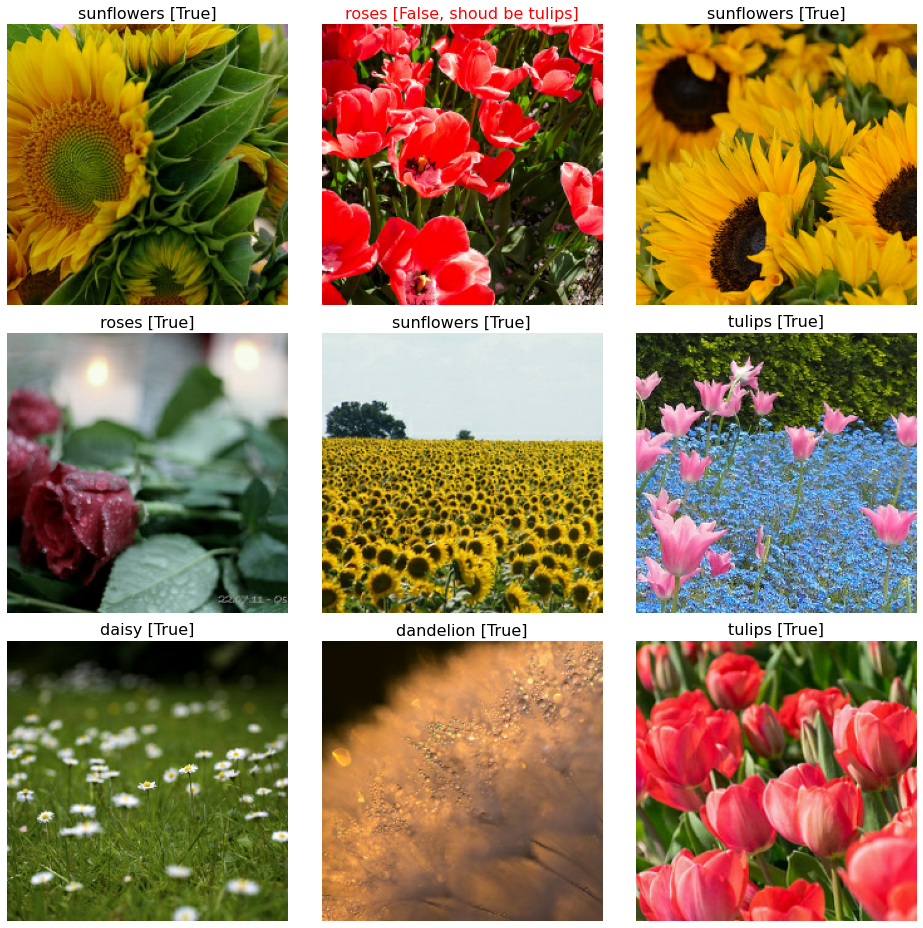

In [12]:
import numpy as np
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = inference_model(some_flowers)

print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

display_9_images_with_predictions(some_flowers, predictions, some_labels)